In [1]:
import os
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW
import torch.nn.functional as F

from utils import test_policy_network, seed_everything, plot_stats
from parallel_env import ParallelEnv, ParallelWrapper

In [2]:
env = gym.make('Acrobot-v1')

In [3]:
dims = env.observation_space.shape[0]
actions = env.action_space.n

print(f"State dimensions: {dims}. Actions: {actions}")
print(f"Sample state: {env.reset()}")

State dimensions: 6. Actions: 3
Sample state: [ 0.99860244 -0.05285042  0.99650748 -0.08350358 -0.06498175  0.06145376]


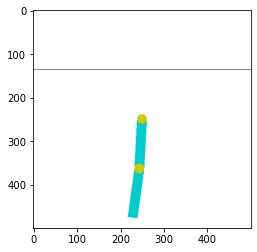

In [4]:
plt.imshow(env.render(mode='rgb_array'))

In [5]:
num_envs = os.cpu_count()

In [6]:
def create_env(env_name, seed):
    env = gym.make(env_name)
    seed_everything(env)
    return env

In [7]:
env_fns = [lambda: create_env('Acrobot-v1', seed=rank) for rank in range(num_envs)]

# [fn,fn,fn]
parallel_env = ParallelEnv(env_fns)

In [8]:
class PreprocessEnv(ParallelWrapper):
    
    def __init__(self, env):
        ParallelWrapper.__init__(self, env)
    
    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()
    
    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)
     
    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [9]:
parallel_env = PreprocessEnv(parallel_env)

In [10]:
policy = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1)
)

In [11]:
value_net = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)

In [14]:
def actor_critic(policy, value_net, episodes, alpha=1e-4, gamma=0.99):
    
    policy_optim = AdamW(policy.parameters(), lr=alpha)
    value_optim = AdamW(value_net.parameters(), lr=alpha)
    stats = {'Actor Loss': [],'Critic Loss': [], 'Returns': []}
    
    for episode in tqdm(range(1, episodes+1)):
        
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool)
        ep_return = torch.zeros((num_envs, 1))
        I = 1
        
        while not done_b.all():
            action = policy(state).multinomial(1).detach()
            next_state, reward, done, _ = parallel_env.step(action)
            
            value = value_net(state)
            target = reward + ~done * gamma * value_net(next_state).detach()
            critic_loss = F.mse_loss(value, target)
            
                        
            value_net.zero_grad()
            critic_loss.backward()
            value_optim.step()
            
            advantage = (target - value).detach()
            probs = policy(state)
            log_probs = torch.log(probs + 1e-6)
            action_log_prob = log_probs.gather(1, action)
            

            entropy = -torch.sum(probs * log_probs, dim=-1, keepdim=True)
            actor_loss = - I * action_log_prob * advantage - 0.01 * entropy
            actor_loss = actor_loss.mean()
            
            policy.zero_grad()
            actor_loss.backward()
            policy_optim.step()

            ep_return += reward
            done_b |= done
            state = next_state
            I = I*gamma
            
        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return.mean().item())
    return stats

In [15]:
stats = actor_critic(policy, value_net, 200)

100%|██████████| 200/200 [01:49<00:00,  1.82it/s]


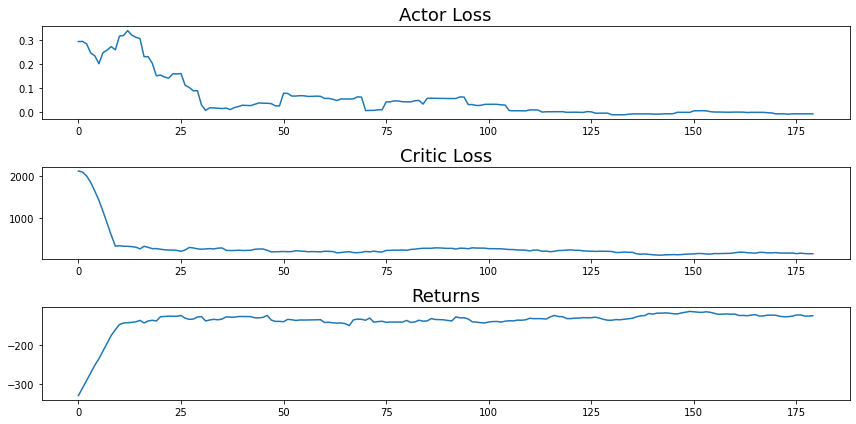

In [16]:
plot_stats(stats)

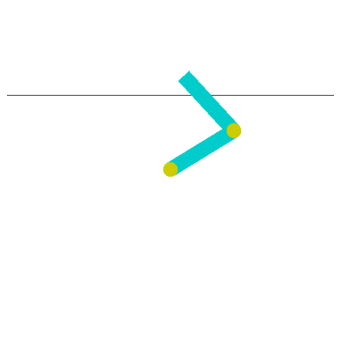

In [18]:
test_policy_network(env, policy, episodes=2)